In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.signal import wiener
from tqdm import tqdm
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(str(Path("..").resolve()))
from src import *

# Fourier Transform

In [2]:
FRAMES=300
astro_x_path = DATASETS["oabf_astro"].dir / "x.tiff"
astro_y_path = DATASETS["oabf_astro"].dir / "y.tiff"
astro_x, astro_y = (Recording(_, max_frames=FRAMES) for _ in [astro_x_path, astro_y_path])
RES_DIR=Path("results/fft/")

In [3]:
fft_x = np.fft.fft(astro_x.np, axis=0)
fft_abs_x = np.abs(fft_x)
fft_angle_x = np.angle(fft_x, deg=True)
del fft_x

In [4]:
fft_y = np.fft.fft(astro_y.np, axis=0)
fft_abs_y = np.abs(fft_y)
fft_angle_y = np.angle(fft_y, deg=True)
del fft_y

In [5]:
dt = 1 / 7  # Astro is 7Hz
freqs = np.fft.fftfreq(astro_x.np.shape[0], d=dt)
rfft_abs_x = fft_abs_x[freqs >= 0]
rfft_abs_y = fft_abs_y[freqs >= 0]
rfft_angle_x = fft_angle_x[freqs >= 0]
rfft_angle_y = fft_angle_y[freqs >= 0]

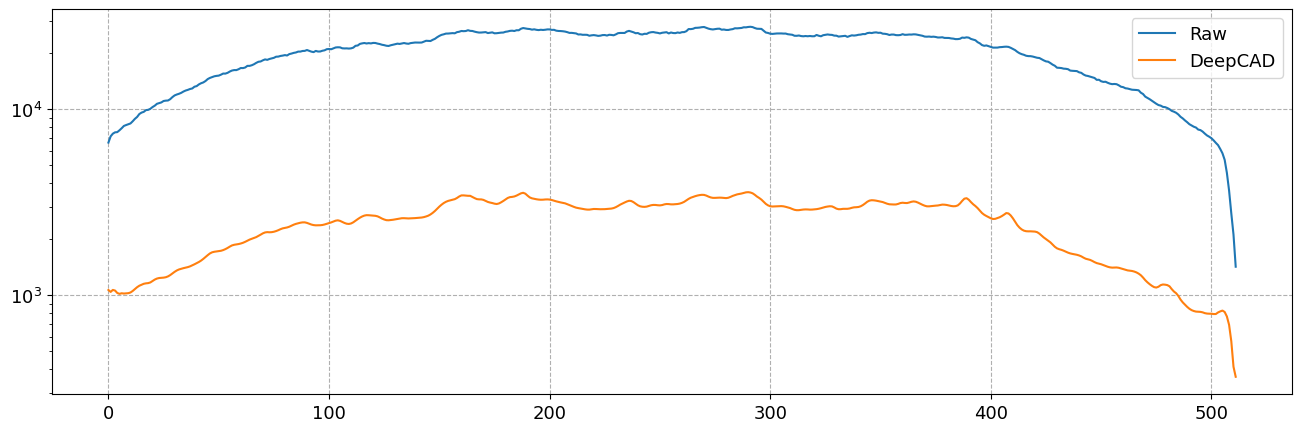

In [6]:
pd.Series(rfft_abs_x.mean(axis=(0, 1))).plot(figsize=(16, 5), label="Raw")
pd.Series(rfft_abs_y.mean(axis=(0, 1))).plot(figsize=(16, 5), label="DeepCAD")
plt.legend()
plt.yscale("log")

In [ ]:
Recording(rfft_abs_x).render("rfft_abs_x.mp4", bitrate=2000, fps=7)
Recording(rfft_abs_y).render("rfft_abs_y.mp4", bitrate=2000, fps=7)
Editor().compose(
    [{"Raw": RES_DIR / "rfft_abs_x.mp4", "DeepCAD": RES_DIR / "rfft_abs_y.mp4"}],
    RES_DIR / "rfft_abs_comb.mp4",
    bitrate=2500,
)

Frequency= 0.00ω


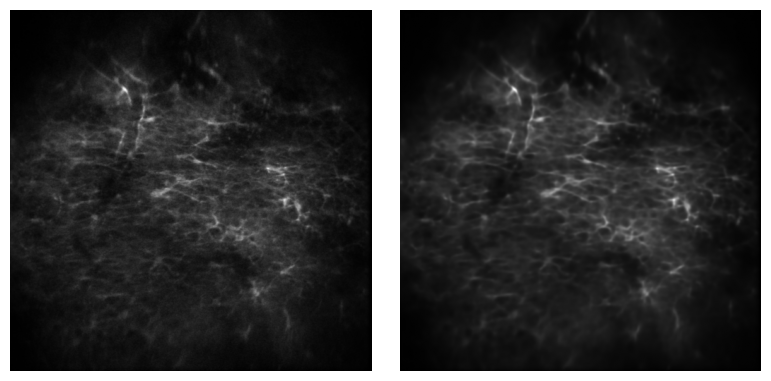

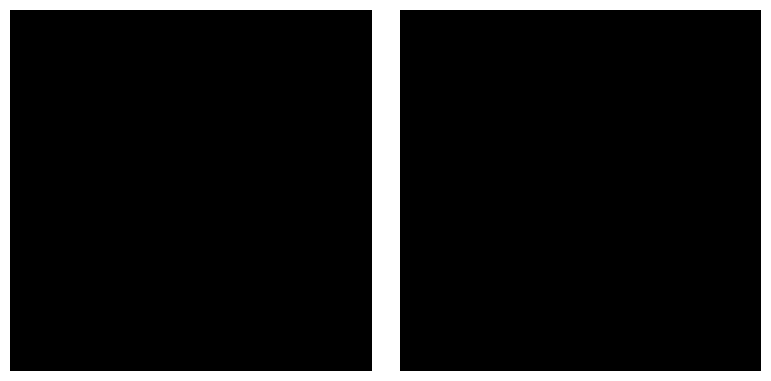

Frequency= 0.02ω


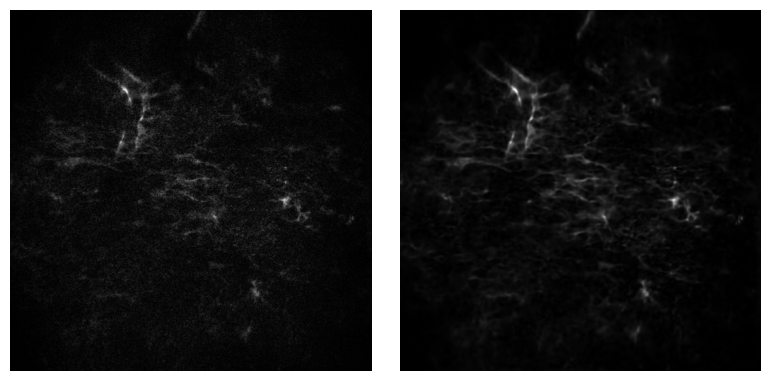

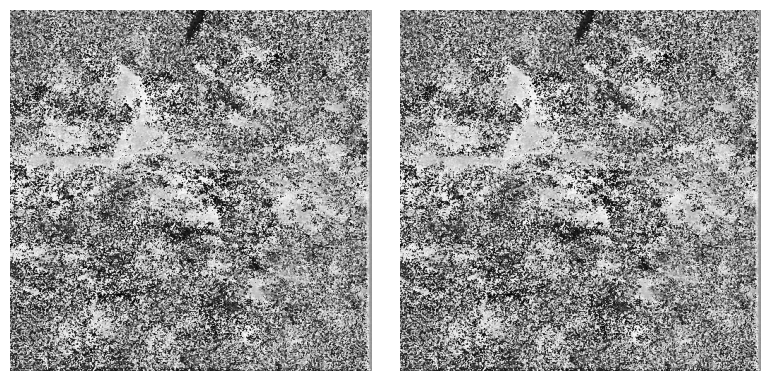

Frequency= 0.05ω


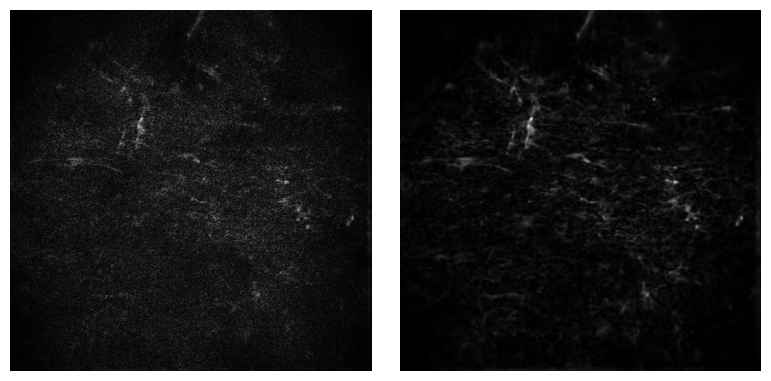

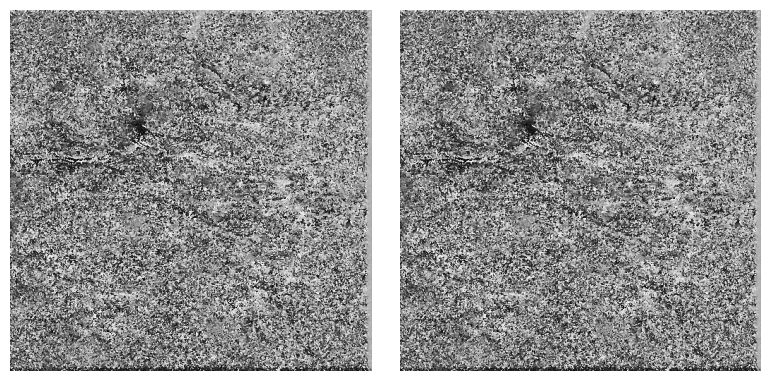

Frequency= 3.48ω


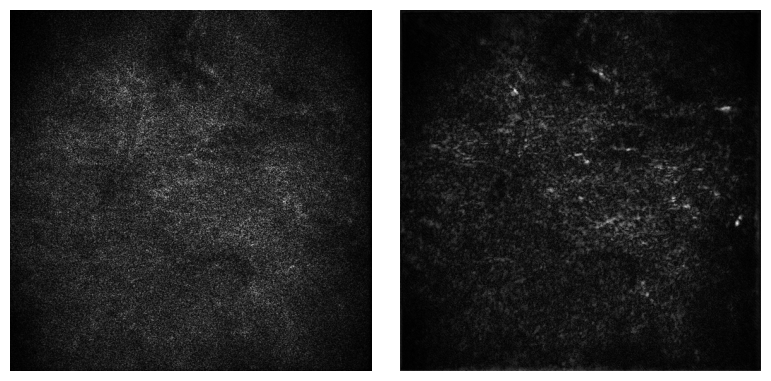

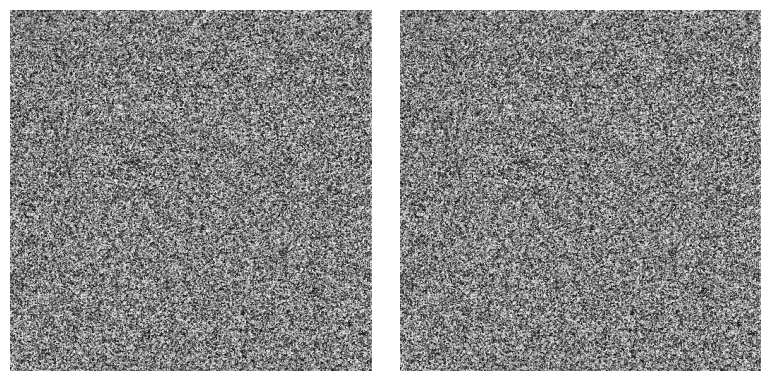

In [73]:
for i in [0, 1, 2, -1]:
    cprint(f"Frequency=", f"cyan:{freqs[freqs>=0][i]:.2f}ω")
    imshow([rfft_abs_x[i], rfft_abs_y[i]])
    imshow([rfft_angle_x[i], rfft_angle_x[i]])

### The magnitude of the lowest-freq frame can be taken from RAW

In [9]:
np.save(RES_DIR/f"{FRAMES}_freq0.npy", fft_abs_x[0])

In [10]:
fft_abs = fft_abs_y
fft_abs[0] = fft_abs_x[0].copy()
del fft_abs_x, fft_angle_x
X = fft_abs_y * np.exp(1j * np.deg2rad(fft_angle_y))
astro_fused = np.fft.ifft(X, axis=0).real

In [ ]:
suffx = FRAMES
Recording(astro_fused).render(f"fft_fusion_{suffx}.mp4", fps=30)
# astro_y.render("astro_y.mp4", fps=30)
Editor().alternate(
    {"FFT Fused": RES_DIR / f"fft_fusion_{suffx}.mp4", "DeepCAD": RES_DIR / "astro_y.mp4"},
    RES_DIR / f"fft_fusion_{suffx}_alt.mp4",
    bitrate=3000,
    delta=1.5,
)
Editor().compose(
    [{"FFT Fused": RES_DIR / f"fft_fusion_{suffx}.mp4", "DeepCAD": RES_DIR / "astro_y.mp4"}],
    RES_DIR / f"fft_fusion_{suffx}_comb.mp4",
    bitrate=3500,
)

In [14]:
np.save(RES_DIR/"astro_fused.npy",astro_fused)